<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>

# Vector Representations
## *Data Science Unit 4 Sprint 2 Assignment 2*

In [1]:
import re
import string

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import spacy

from bs4 import BeautifulSoup

## 1) *Clean:* Job Listings from indeed.com that contain the title "Data Scientist" 

You have `job_listings.csv` in the data folder for this module. The text data in the description column is still messy - full of html tags. Use the [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) library to clean up this column. You will need to read through the documentation to accomplish this task. 

In [25]:
from bs4 import BeautifulSoup
import requests

df = pd.read_csv('./data/job_listings.csv', index_col=0)
df

,description,title
0,"b""<div><div>Job Requirements:</div><ul><li><p>...",Data scientist
1,b'<div>Job Description<br/>\n<br/>\n<p>As a Da...,Data Scientist I
2,b'<div><p>As a Data Scientist you will be work...,Data Scientist - Entry Level
3,"b'<div class=""jobsearch-JobMetadataHeader icl-...",Data Scientist
4,b'<ul><li>Location: USA \xe2\x80\x93 multiple ...,Data Scientist
...,...,...
421,"b""<b>About Us:</b><br/>\nWant to be part of a ...",Senior Data Science Engineer
422,"b'<div class=""jobsearch-JobMetadataHeader icl-...",2019 PhD Data Scientist Internship - Forecasti...
423,"b'<div class=""jobsearch-JobMetadataHeader icl-...",Data Scientist - Insurance
424,"b""<p></p><div><p>SENIOR DATA SCIENTIST</p><p>\...",Senior Data Scientist


In [27]:
X = df.description
df['description'] = [BeautifulSoup(X).getText() for X in df['description']]

In [28]:
df.head()

,description,title
0,"b""Job Requirements:\nConceptual understanding ...",Data scientist
1,"b'Job Description\n\nAs a Data Scientist 1, yo...",Data Scientist I
2,b'As a Data Scientist you will be working on c...,Data Scientist - Entry Level
3,"b'$4,969 - $6,756 a monthContractUnder the gen...",Data Scientist
4,b'Location: USA \xe2\x80\x93 multiple location...,Data Scientist


## 2) Use Spacy to tokenize the listings 

In [51]:
# function to 
def get_lemmas(text):

    lemmas = []
    
    doc = nlp(text)

    for token in doc: 
        if ((token.is_stop == False) and (token.is_punct == False)) and (token.pos_ != 'PRON'):
            lemmas.append(token.lemma_)
    
    return lemmas

In [37]:
import spacy
nlp = spacy.load("en_core_web_lg")

lemmas = []

for doc in nlp.pipe(df['description']):
    
    doc_tokens = []
    
    for token in doc:
        if ((token.is_stop == False) and (token.is_punct == False)) and (token.pos_ != 'PRON'):
            doc_tokens.append(token.lemma_)
            
    lemmas.append(doc_tokens)
        
df['lemmas'] = lemmas    

In [38]:
df.head()

,description,title,lemmas
0,"b""Job Requirements:\nConceptual understanding ...",Data scientist,"[b""Job, requirements:\nconceptual, understandi..."
1,"b'Job Description\n\nAs a Data Scientist 1, yo...",Data Scientist I,"[b'Job, description\n\na, Data, scientist, 1, ..."
2,b'As a Data Scientist you will be working on c...,Data Scientist - Entry Level,"[b'As, Data, scientist, work, consult, busines..."
3,"b'$4,969 - $6,756 a monthContractUnder the gen...",Data Scientist,"[b'$4,969, $, 6,756, monthcontractunder, gener..."
4,b'Location: USA \xe2\x80\x93 multiple location...,Data Scientist,"[b'Location, USA, \xe2\x80\x93, multiple, loca..."


## 3) Use Scikit-Learn's CountVectorizer to get word counts for each listing.

In [55]:
# list of text documents
text = df['description']

# create the transformer
vect = CountVectorizer(max_features=1000, tokenizer=get_lemmas)

# build vocab
vect.fit(text)

# transform text
dtm = vect.transform(text)

C:\Users\nirma\anaconda3\envs\U4-S1-NLP\lib\site-packages\sklearn\feature_extraction\text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


In [56]:
dtm

<426x1000 sparse matrix of type '<class 'numpy.int64'>'
	with 61571 stored elements in Compressed Sparse Row format>

In [57]:
dtm.todense()

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 1, 2, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [1, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [58]:
dtm = pd.DataFrame(dtm.todense(), columns=vect.get_feature_names())
dtm

,$,+,1,10,100,2,2019,3,4,5,...,world\xe2\x80\x99s,worldwide,write,writing,year,years\xe2\x80\x99,york,you\'ll,you\xe2\x80\x99ll,||
0,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,0,1,2,0,0,0,0,0,0,0,...,0,0,2,1,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421,1,2,1,0,0,0,0,0,1,0,...,0,0,0,0,4,0,1,0,1,0
422,0,0,0,0,0,0,1,1,0,0,...,0,0,1,0,0,0,0,2,0,0
423,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
424,0,0,0,0,0,0,0,0,0,1,...,1,0,0,0,1,0,0,0,0,0


In [60]:
len(vect.get_feature_names())

1000

## 4) Visualize the most common word counts

In [65]:
import squarify

wc = dtm.sum().sort_values(ascending=False)
wc

datum          2934
work           1369
data           1270
team           1199
business       1171
               ... 
price            20
interested       20
meeting          20
interactive      20
let              20
Length: 1000, dtype: int64

In [67]:
top20 = wc.head(20)

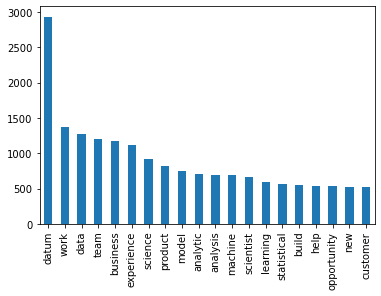

In [69]:
top20.plot.bar()
plt.show()

## 5) Use Scikit-Learn's tfidfVectorizer to get a TF-IDF feature matrix

In [70]:
tfidf = TfidfVectorizer(max_features=5000, tokenizer = get_lemmas)

dtm = tfidf.fit_transform(df['description'])

dtm = pd.DataFrame(dtm.todense(), columns=tfidf.get_feature_names())
print(dtm.shape)
dtm.head()

(426, 5000)


,$,+,.\n\nabout,.\n\nperks\n\nhealth,/or,0,1,1-800-flowers.com,10,100,...,you\xe2\x80\x99ve,young,yrs,zeus,zf,zf\xe2\x80\x99s,zillow,|,||,~1
0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.031178,0.0,0.0,0.0,0.0,0.117563,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.193214,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.179242,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 6) Create a NearestNeighbor Model. Write the description of your ideal datascience job and query your job listings. 

In [71]:
from sklearn.neighbors import NearestNeighbors

# Fit on DTM
nn = NearestNeighbors(n_neighbors=5, algorithm='kd_tree')
nn.fit(dtm)

NearestNeighbors(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [74]:
nn.kneighbors([dtm.iloc[425].values])

(array([[0.        , 1.19685053, 1.22665086, 1.23317466, 1.24089706]]),
 array([[425, 201, 388, 406, 383]], dtype=int64))

In [77]:
description = ['''
                Undertaking data collection, preprocessing, and analysis. Also building models to address business problems to help them understand data and how it does impact business decisions.
                Presenting information using data visualization techniques.
              ''']

In [78]:
new = tfidf.transform(description)
new

<1x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 17 stored elements in Compressed Sparse Row format>

In [79]:
nn.kneighbors(new.todense())

(array([[1.24234295, 1.25350307, 1.25761816, 1.25840356, 1.25843659]]),
 array([[393, 390, 163, 326, 217]], dtype=int64))

In [82]:
df['description'][393]

"b'Job Title\\nData Scientist\\nPosition Overview\\nPosition Objective\\nThe data scientist is responsible for modeling complex business problems and discovering business insights through the use of statistical, algorithmic, mining, and visualization techniques. The data scientist contributes to building and developing the organization\\xe2\\x80\\x99s data infrastructure as it relates to Workforce Analytics with insights, management reports, and analysis for decision making processes.\\nResponsibilities\\n\\xc2\\xb7 Establish strong cross-functional relationships to fully understand the business and factors of success in the industry.\\n\\xc2\\xb7 Translates business needs into analytics to support business decisions and workflows.\\n\\xc2\\xb7 Proactively mines data warehouses to identify trends and patterns and generates insights for business units and senior leadership.\\n\\xc2\\xb7 Performs large scale experimentation to identify hidden relationships between variables in large data

## Stretch Goals

 - Try different visualizations for words and frequencies - what story do you want to tell with the data?
 - Scrape Job Listings for the job title "Data Analyst". How do these differ from Data Scientist Job Listings
 - Try and identify requirements for experience specific technologies that are asked for in the job listings. How are those distributed among the job listings?
 - Use a clustering algorithm to cluster documents by their most important terms. Do the clusters reveal any common themes?
  - **Hint:** K-means might not be the best algorithm for this. Do a little bit of research to see what might be good for this. Also, remember that algorithms that depend on Euclidean distance break down with high dimensional data.
 - Create a labeled dataset - which jobs will you apply for? Train a model to select the jobs you are most likely to apply for. :) 